# Imports

In [1]:
%matplotlib inline
from itertools import combinations, product

from readdy._internal.api import KernelProvider, Simulation
from readdy._internal.common import Vec

from readdy.util import platform_utils
import numpy as np
import matplotlib

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Set up simulation

In [2]:
# load kernels
KernelProvider.get().load_from_dir(platform_utils.get_readdy_plugin_dir())

In [3]:
# parameters
box_size = Vec(2.0, 2.0, 2.0)
depth = 2.
desired_dist = .25
force_constant = 4 * depth / (desired_dist * desired_dist)
no_interaction_dist = 1.5

In [4]:
# create simulation object
simulation = Simulation()
simulation.set_kernel("CPU")
simulation.kbt = 0.01
simulation.periodic_boundary = [False, False, False]
simulation.box_size = box_size
simulation.register_particle_type("A", .1, .1)
simulation.register_particle_type("B", .01, .1)
simulation.register_particle_type("C", .5, .1)
simulation.register_potential_piecewise_weak_interaction("A", "B", force_constant, desired_dist, depth,
                                                         no_interaction_dist)  # (force constant, desired dist, depth, no interaction dist)
simulation.register_reaction_fusion("fusion", "A", "B", "C", 100., .3, .5, .5)
simulation.register_reaction_fission("fission", "C", "A", "B", 100., .25, .5, .5)
simulation.register_potential_box("A", 100., Vec(-.75, -.75, -.75), Vec(1.5, 1.5, 1.5), False)
simulation.register_potential_box("B", 100., Vec(-.75, -.75, -.75), Vec(1.5, 1.5, 1.5), False)
simulation.register_potential_box("C", 100., Vec(-.75, -.75, -.75), Vec(1.5, 1.5, 1.5), False)
simulation.add_particle("A", Vec(-.0, -.0, -.0))
simulation.add_particle("B", Vec(0.1, 0.1, 0.1))

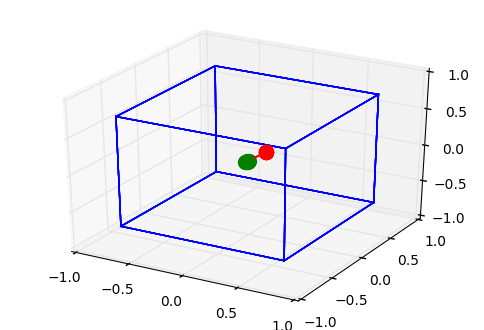

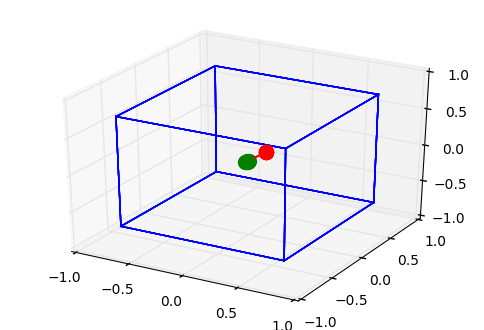

In [5]:
# plotting
from IPython import display
import time

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plt.ioff()
fig.show()
prev_pos = {}
current_plot = None

# define observable callback function
def ppos_callback(pos):
    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_zlim([-1, 1])
    r = [-.75, .75]
    for s, e in combinations(np.array(list(product(r, r, r))), 2):
        if np.sum(np.abs(s - e)) == r[1] - r[0]:
            ax.plot3D(*zip(s, e), color="b")
    pA = simulation.get_particle_positions("A")
    pB = simulation.get_particle_positions("B")
    if len(pA) == 1 and len(pB) == 1:
        A = pA[0]; B = pB[0]
        ax.scatter([A[0]], [A[1]], [A[2]], color="g", s=100)
        ax.scatter([B[0]], [B[1]], [B[2]], color="r", s=100)
        ax.plot3D([A[0], B[0]], [A[1], B[1]], [A[2], B[2]], color="r")
    pC = simulation.get_particle_positions("C")
    if len(pC) == 1:
        C = pC[0]
        ax.scatter([C[0]], [C[1]], [C[2]], color="b", s=100)
    display.clear_output(wait=True)
    display.display(plt.gcf())
    plt.pause(.001)
    
# register observable
observable_handle = simulation.register_observable_particle_positions(1, ppos_callback, [])

# run for T timesteps
T = 5
fig.show()
simulation.run(T, .0001)